In [1]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [4]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [5]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [6]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
#fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  #fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [7]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx]

batch = 125
msd = MosaicDataset(mosaic_list_of_images, mosaic_label )
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [8]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [9]:
test_data = MosaicDataset(test_images,test_label)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [10]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # print(x.shape)
    x = (F.relu(self.conv3(x)))
    x =  x.view(x.size(0), -1)
    # print(x.shape)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [11]:
class Classification(nn.Module):
  def __init__(self,focus_net):
    super(Classification, self).__init__()
    self.module1 = focus_net
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")

    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    # print(x.shape)
    y1 = (F.relu(self.conv3(y1)))
    y1 =  y1.view(y1.size(0), -1)
    # print(x.shape)
    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)

    return y1 , x, y

In [120]:
# both trained
focus_net = Focus().double()
for params in focus_net.parameters():
  params.requires_grad = True
classify = Classification(focus_net).double()
classify = classify.to("cuda")
classify.load_state_dict( torch.load("/content/brandom_btrain.pt"))

<All keys matched successfully>

In [121]:
#classify trained
focus_ct = Focus().double()
for params in focus_ct.parameters():
  params.requires_grad = True
classify_ct = Classification(focus_ct).double()
classify_ct = classify_ct.to("cuda")
classify_ct.load_state_dict( torch.load("/content/brandom_ctrain.pt"))

<All keys matched successfully>

In [16]:
# import torch.optim as optim
# criterion_classify = nn.CrossEntropyLoss()
# optimizer_classify = optim.SGD(classify.parameters(), lr=0.01, momentum=0.9)


In [17]:
# nos_epochs =300
# for epoch in range(nos_epochs):  # loop over the dataset multiple times  
#   running_loss = 0.0
#   epoch_loss = []
#   cnt=0

#   iteration = desired_num // batch
  
#   #training data set
  
#   for i, data in  enumerate(train_loader):
#     inputs , labels = data
#     inputs = inputs.double()
#     inputs, labels = inputs.to("cuda"), labels.to("cuda")
#     # zero the parameter gradients
    
#     optimizer_classify.zero_grad()
#     outputs, alphas, avg_images = classify(inputs)

#     _, predicted = torch.max(outputs.data, 1)
# #     print(outputs)
# #     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

#     loss = criterion_classify(outputs, labels) 
#     loss.backward()
#     optimizer_classify.step()

#     running_loss += loss.item()
#     mini = 60
#     if cnt % mini == mini-1:    # print every 40 mini-batches
#       print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
#       epoch_loss.append(running_loss/mini)
#       running_loss = 0.0
#     cnt=cnt+1
#   if(np.mean(epoch_loss) <= 0.03):
#       break;
# print('Finished Training')

In [18]:
# torch.save(classify.state_dict(),"/content/brandom_ctrain.pt")

In [19]:
#classify.load_state_dict( torch.load("/content/brandom_ctrain.pt"))
#classify.load_state_dict( torch.load("/content/drive/My Drive/Cheating_data/16_experiments_on_cnn_3layers/4_focus_random_classify_random_train_classify.pt"))

In [22]:
# classify.eval()
# total = 0 
# correct = 0
# with torch.no_grad():
#   for data in train_loader:
#     inputs, labels  = data
#     inputs = inputs.double()
#     inputs, labels  = inputs.to("cuda"),labels.to("cuda")
#     outputs, alphas, avg_images = classify(inputs)

#     _, predicted = torch.max(outputs.data, 1)

#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 30000 train images: %d %%' % (
#     100 * correct / total))
# print("total correct", correct)
# print("total train set images", total)

In [23]:
# classify_ct.eval()
# total = 0 
# correct = 0
# with torch.no_grad():
#   for data in test_loader:
#     inputs, labels  = data
#     inputs = inputs.double() 
#     inputs, labels  = inputs.to("cuda"),labels.to("cuda")
#     outputs, alphas, avg_images = classify_ct(inputs)

#     _, predicted = torch.max(outputs.data, 1)

#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))
# print("total correct", correct)
# print("total train set images", total)

# Analysis on both random train classify Model

In [24]:
MIN = 100000
MAX = -100000
i=0
for param in classify_ct.parameters():
  if i %2 == 0:
    min_value = np.min(param.cpu().detach().numpy())
    max_value = np.max(param.cpu().detach().numpy())
    if MIN > min_value:
      MIN = min_value
    if MAX < max_value:
      MAX = max_value 
  i =i+1

In [25]:
MIN,MAX

(-1.2860045929276889, 1.7312222026163304)

In [33]:
classify_ct.eval()
margin = []
with torch.no_grad():
  for data in train_loader:
    inputs, labels  = data
    inputs = inputs.double() 
    inputs  = inputs.to("cuda")
    output, alphas, avg_images = classify_ct(inputs)
    output = output.cpu().detach().numpy()
    indexes = np.arange(output.shape[0]), np.argsort(output, axis=1)[:, -2]
    second_largest = output[indexes]
    margin.append(np.diag(output[:,labels]) - second_largest)

margin = np.concatenate(margin,axis=0)
margin = np.percentile(margin[margin>0],5)
print(margin)

4.010290425296221


(30000,)


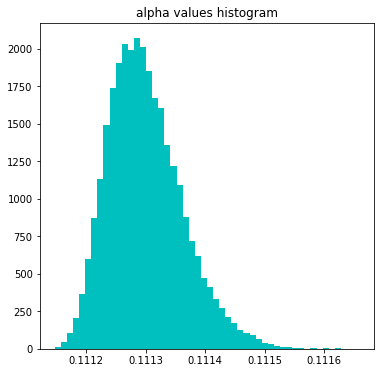

In [179]:
max_alpha =[]
for i, data in  enumerate(train_loader):
  inputs , labels = data
  inputs = inputs.double()
  inputs, labels = inputs.to("cuda"), labels.to("cuda")
  _, alphas, _ = classify_ct(inputs)
  mx,_ = torch.max(alphas,1)
  max_alpha.append(mx.cpu().detach().numpy())
max_alpha = np.concatenate(max_alpha,axis=0)
print(max_alpha.shape)
plt.figure(figsize=(6,6))
_,bins,_ = plt.hist(max_alpha,bins=50,color ="c")
plt.title("alpha values histogram")
plt.savefig("attention_model_2_hist")

In [51]:
norm_weight = 1
i = 0
for weights in classify_ct.parameters():
  norm_weight *= np.linalg.norm(weights.cpu().detach().numpy())**2
  i =i+1

print(norm_weight)

255042257838873.97


In [105]:
with torch.no_grad():
  for p in classify_ct.parameters():
    p.data.copy_( (p*p).data)

In [117]:
inputs = torch.tensor(np.ones(next(iter(train_loader))[0].shape)).to("cuda")
outputs,_,_ = classify_ct(inputs)
path_norm = np.sqrt(np.sum(outputs[0].cpu().detach().numpy()))
print(path_norm)

110.62136599654703


# Sharpness


# Analysis on both random train both Model

In [28]:
MIN = 100000
MAX = -100000
i = 0
for param in classify.parameters():
  if i %2 == 0:
    min_value = np.min(param.cpu().detach().numpy())
    max_value = np.max(param.cpu().detach().numpy())
    if MIN > min_value:
      MIN = min_value
    if MAX < max_value:
      MAX = max_value 
  i = i+1

In [29]:
MIN,MAX

(-1.2381426818007577, 1.1129292140413958)

In [32]:
classify.eval()
margin = []
with torch.no_grad():
  for data in train_loader:
    inputs, labels  = data
    inputs = inputs.double() 
    inputs  = inputs.to("cuda")
    output, alphas, avg_images = classify(inputs)
    output = output.cpu().detach().numpy()
    indexes = np.arange(output.shape[0]), np.argsort(output, axis=1)[:, -2]
    second_largest = output[indexes]
    margin.append(np.diag(output[:,labels]) - second_largest)

margin = np.concatenate(margin,axis=0)
margin = np.percentile(margin[margin>0],5)
print(margin)

3.628978227614205


In [50]:
norm_weight = 1
i = 0 
for weights in classify.parameters():
  norm_weight *= np.linalg.norm(weights.cpu().detach().numpy())
print(norm_weight)

66608444571.48307


In [118]:
with torch.no_grad():
  for p in classify.parameters():
    p.data.copy_( (p*p).data)

In [119]:
inputs = torch.tensor(np.ones(next(iter(train_loader))[0].shape)).to("cuda")
outputs,_,_ = classify(inputs)
path_norm = np.sqrt(np.sum(outputs[0].cpu().detach().numpy()))
print(path_norm)

4.766916528253006


(30000,)


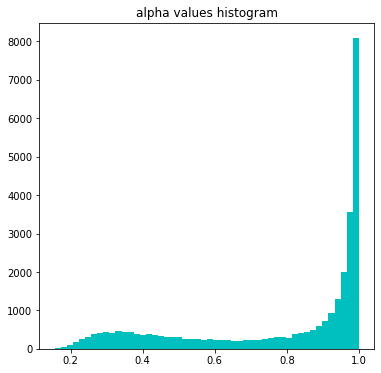

In [180]:
max_alpha =[]
for i, data in  enumerate(train_loader):
  inputs , labels = data
  inputs = inputs.double()
  inputs, labels = inputs.to("cuda"), labels.to("cuda")
  _, alphas, _ = classify(inputs)
  mx,_ = torch.max(alphas,1)
  max_alpha.append(mx.cpu().detach().numpy())
max_alpha = np.concatenate(max_alpha,axis=0)
print(max_alpha.shape)
plt.figure(figsize=(6,6))
_,bins,_ = plt.hist(max_alpha,bins=50,color ="c")
plt.title("alpha values histogram")
plt.savefig("attention_model_1_hist")

# Sharpness
